In [1]:
#Libraries
import os
import pandas as pd
import numpy as np
import keras
import tensorflow
import sklearn
from matplotlib import pyplot as plt
import sys
import surfboard
from surfboard.feature_extraction_multiprocessing import extract_features

Using TensorFlow backend.


In [2]:
#Misc. adjustments
pd.set_option('max_colwidth', 200)

In [9]:
#Listing files
filelist = os.listdir("Source/vox")

#Read files into pandas
source = pd.DataFrame(filelist)
#Rename file name column
source = source.rename(columns={0:'file'})
#Filter out DS files from macOS
source = source[source.file != ".DS_Store"]
#Reset index
source = source.reset_index(drop = True)

#Extraction of variables from filenames
speaker_id = []
condition = []
index = []

for i in range (0, len(source)):
    id = source["file"][i][0:2]
    con = source["file"][i][3]
    indx = source["file"][i][5:7]
    
    if id[0:1] == "0":
        speaker_id.append(id[1])
    else:
        speaker_id.append(id)
    
    if indx[0:1] == "0":
        index.append(indx[1])
    else:
        index.append(indx)
    
    condition.append(con)
    
#Adding variables to dataframe
source["id"] = speaker_id
source["condition"] = condition
source["indx"] = index


source.file = os.path.join(sys.path[0], "Source/vox/") + source.file
source_files = source["file"].tolist()

features = surfboard.feature_extraction_multiprocessing.extract_features_from_paths(source_files, ["mfcc", 'f0_statistics', 'formants'], statistics_list=['mean'], sample_rate=44100, num_proc=3)
source = pd.concat([source, features], axis=1, sort=False)

source.head()

Extracting features from paths...: 100%|██████████| 320/320 [00:36<00:00,  8.76it/s]


,file,id,condition,indx,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,...,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_mean_13,f0_mean,f0_std,f1,f2,f3,f4
0,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/08-2-09.wav,8,2,9,-521.157104,71.668144,2.469791,20.627808,4.826080,20.991871,...,1.341210,3.135353,5.152745,2.333008,133.692743,20.545576,491.477172,1342.991439,2512.375225,3654.489603
1,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/10-2-06.wav,10,2,6,-486.532379,121.979752,-11.939642,27.319185,28.309999,18.014025,...,-7.956030,-2.497566,-0.142808,0.333498,104.349537,9.761097,1336.471135,2554.986935,3602.078416,4423.840882
2,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/11-2-12.wav,11,2,12,-508.592468,86.788513,14.815022,24.903181,15.770222,20.520506,...,4.253114,4.698157,2.170210,2.492243,113.496730,15.852238,306.285480,1180.233501,2478.401299,3531.644650
3,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/11-2-06.wav,11,2,6,-460.006317,93.882835,6.611367,23.654299,15.736868,18.022600,...,0.273451,-1.206936,-2.379301,-2.514076,149.818298,24.477652,2363.982891,3035.140787,3516.793534,4717.544723
4,/Users/jthiepler/Documents/GitHub/voice-classifier/Source/vox/10-2-12.wav,10,2,12,-459.002716,84.031883,0.104489,24.154739,23.022877,9.668544,...,-4.667840,-0.632747,2.106734,0.663641,114.057808,20.053377,497.779279,1313.940418,2521.736585,3594.574586


In [21]:
#Create Training & Valuation Sets
def create_sets(subjects, n_train, n_val, conditions):
    train_set = pd.DataFrame()
    val_set = pd.DataFrame()
    selection = subjects
    
    if isinstance(conditions[0], tuple):
        for i in selection:
            tmp_train = source[(source.id==str(i)) & (source.condition==conditions[0][0])]
            tmp_train2 = source[(source.id==str(i)) & (source.condition==conditions[0][1])]
            tmp_train = tmp_train.sample(int(n_train/2))
            ind = tmp_train["indx"].tolist()
            tmp_train2 = tmp_train2[tmp_train2["indx"].isin(ind) == False]
            tmp_train2 = tmp_train2.sample(int(n_train/2))
            tmp_train = tmp_train.append(tmp_train2)
            train_set = train_set.append(tmp_train)
            ind = tmp_train["indx"].tolist()
            
            #print("y")
            
            tmp_val = source[(source.id==str(i)) & (source.condition==conditions[1])]
            tmp_val2 = tmp_val[tmp_val["indx"].isin(ind) == False]
            val_set = val_set.append(tmp_val2.sample(n_val))
    else:
        for i in selection:
            tmp_train = source[(source.id==str(i)) & (source.condition==conditions[0])]
            tmp_train = tmp_train.sample(n_train)
            train_set = train_set.append(tmp_train)
            ind = tmp_train["indx"].tolist()
            
            #print("x")
            
            tmp_val = source[(source.id==str(i)) & (source.condition==conditions[1])]
            tmp_val2 = tmp_val[tmp_val["indx"].isin(ind) == False]
            val_set = val_set.append(tmp_val2.sample(n_val))


    train_set = train_set.reset_index()
    val_set = val_set.reset_index()

    X_train = train_set.drop(train_set.columns[[0, 1, 2, 3, 4]], axis=1)
    X_val = val_set.drop(val_set.columns[[0, 1, 2, 3, 4]], axis=1)
    
    np.array(X_train)
    np.array(X_val)
    
    return train_set, val_set, X_train, X_val

In [11]:
#Pre-Processing
def processing(X_train, X_val, train_set, val_set):
    y_train = np.array(train_set["id"])
    y_val = np.array(val_set["id"])
    
    from sklearn.preprocessing import LabelEncoder
    from keras.utils.np_utils import to_categorical
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_val = to_categorical(lb.fit_transform(y_val))
    
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)
    #X_test = ss.transform(X_test)
    
    return y_train, y_val, X_train, X_val

In [12]:
#Build Model
def build_model(n_speakers):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.callbacks import EarlyStopping
    model = Sequential()
    model.add(Dense(19, input_shape=(19,), activation = 'relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(128, activation = 'relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(128, activation = 'relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(6, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
    
    return model, early_stop


In [13]:
#Train Model
def train_model(model, early_stop, log=0, graph=0):
    history = model.fit(X_train, y_train, batch_size=20, epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stop], verbose = log)
    
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    if graph == 1:
        plt.figure(figsize=(12, 8))
        plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
        plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
        plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
        plt.xlabel('Epoch', fontsize = 18)
        plt.ylabel('Categorical Crossentropy', fontsize = 18)
        plt.xticks(range(0,100,5), range(0,100,5))
        plt.legend(fontsize = 18);
    
    return val_accuracy

1/125
2/125
3/125
4/125
5/125
6/125
7/125
8/125
9/125
10/125
11/125
12/125
13/125
14/125
15/125
16/125
17/125
18/125
19/125
20/125
21/125
22/125
23/125
24/125
25/125
26/125
27/125
28/125
29/125
30/125
31/125
32/125
33/125
34/125
35/125
36/125
37/125
38/125
39/125
40/125
41/125
42/125
43/125
44/125
45/125
46/125
47/125
48/125
49/125
50/125
51/125
52/125
53/125
54/125
55/125
56/125
57/125
58/125
59/125
60/125
61/125
62/125
63/125
64/125
65/125
66/125
67/125
68/125
69/125
70/125
71/125
72/125
73/125
74/125
75/125
76/125
77/125
78/125
79/125
80/125
81/125
82/125
83/125
84/125
85/125
86/125
87/125
88/125
89/125
90/125
91/125
92/125
93/125
94/125
95/125
96/125
97/125
98/125
99/125
100/125
101/125
102/125
103/125
104/125
105/125
106/125
107/125
108/125
109/125
110/125
111/125
112/125
113/125
114/125
115/125
116/125
117/125
118/125
119/125
120/125
121/125
122/125
123/125
124/125
125/125


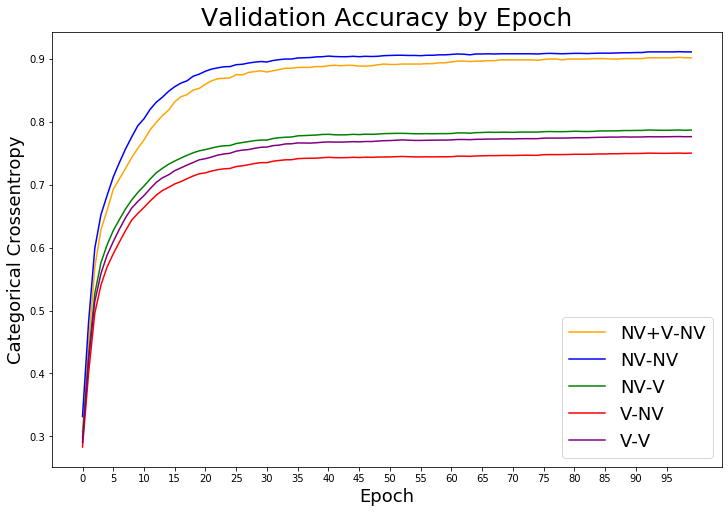

In [34]:
#Parameters
selection=(1,3,5,8,10,11)
n_train = 10
n_val = 20-n_train
conditions = [(("0","2"),"0"),("0","0"),("0","2"),("2","0"),("2","2")]
labels = ["NV+V-NV","NV-NV", "NV-V", "V-NV", "V-V"]
iterations = 25
n_speakers = len(selection)
log = 0
graph = 0

results = []
avg_results= []
colours = ["orange", "blue", "green", "red", "purple"]

for i in range(len(conditions)):
    for j in range(iterations):
        
        #Creating sets
        [train_set, val_set, X_train, X_val] = create_sets(selection, n_train, n_val, conditions[i])
        
        #Pre-Processing
        [y_train, y_val, X_train, X_val] = processing(X_train, X_val, train_set, val_set)

        #Build model
        [model, early_stop] = build_model(n_speakers)

        #Train
        result = train_model(model, early_stop, log, graph)
        results.append(result)
        
        #Progress Counter
        print(str(1+j+i*iterations) + "/" + str(iterations * len(conditions)))
        
    #Sum accuracy from all runs
    sum_results = [0] * len(results[0])
    for i in range (0, len(results)):
        sum_results = np.add(sum_results, results[i])

    #Take average of accuracy from all runs
    avg_results.append([x / len(results) for x in sum_results])
    
plt.figure(figsize=(12, 8))
for i in range(len(conditions)):
    plt.plot(avg_results[i], label=labels[i], color=colours[i])
plt.title('Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))
plt.legend(fontsize = 18);